In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
HIGH_PERFORMANCE = False
DYNAMO_DEBUG = False
COMPILE = True
SHOW_ANIMATION = True

In [3]:
%env TORCH_LOGS=dynamo 
%env TORCHDYNAMO_VERBOSE=1

env: TORCH_LOGS=dynamo
env: TORCHDYNAMO_VERBOSE=1


In [4]:
import torch
import matplotlib.pyplot as plt
from flipper_training.configs import *
from flipper_training.engine.engine import DPhysicsEngine, PhysicsState, PhysicsStateDer
from flipper_training.utils.dynamics import *
from flipper_training.utils.geometry import *
from flipper_training.utils.environment import *
from flipper_training.utils.numerical import *
from copy import deepcopy
from collections import deque

In [5]:
from flipper_training.utils.torch_utils import autodevice

device = autodevice(HIGH_PERFORMANCE)

In [6]:
from flipper_training.vis.static_vis import *

In [7]:
torch.random.manual_seed(420)

In [8]:
num_robots = 1

In [9]:
# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 6.4  # meters
DIM = int(2 * max_coord / grid_res)
xint = torch.linspace(-max_coord, max_coord, DIM)
yint = torch.linspace(-max_coord, max_coord, DIM)
x, y = torch.meshgrid(xint, yint, indexing='xy')

In [10]:
# gaussian hm
z = (1.0 * torch.exp(-0.5 * ((x - 0)**2 + (y - 4)**2)) +
     0.0 * torch.exp(-0.3 * ((x - 1)**2 + (y + 2)**2)) +
     2.0 * torch.exp(-0.1 * ((x + max_coord)**2 + (y + max_coord)**2))
     ) + 0.01 * torch.randn_like(x) + torch.exp(-0.03 * ((x + 5)**2 + (y + 5)**2))
x_grid = x.repeat(num_robots, 1, 1)
y_grid = y.repeat(num_robots, 1, 1)
z_grid = z.repeat(num_robots, 1, 1)
x_grid.shape

torch.Size([1, 256, 256])

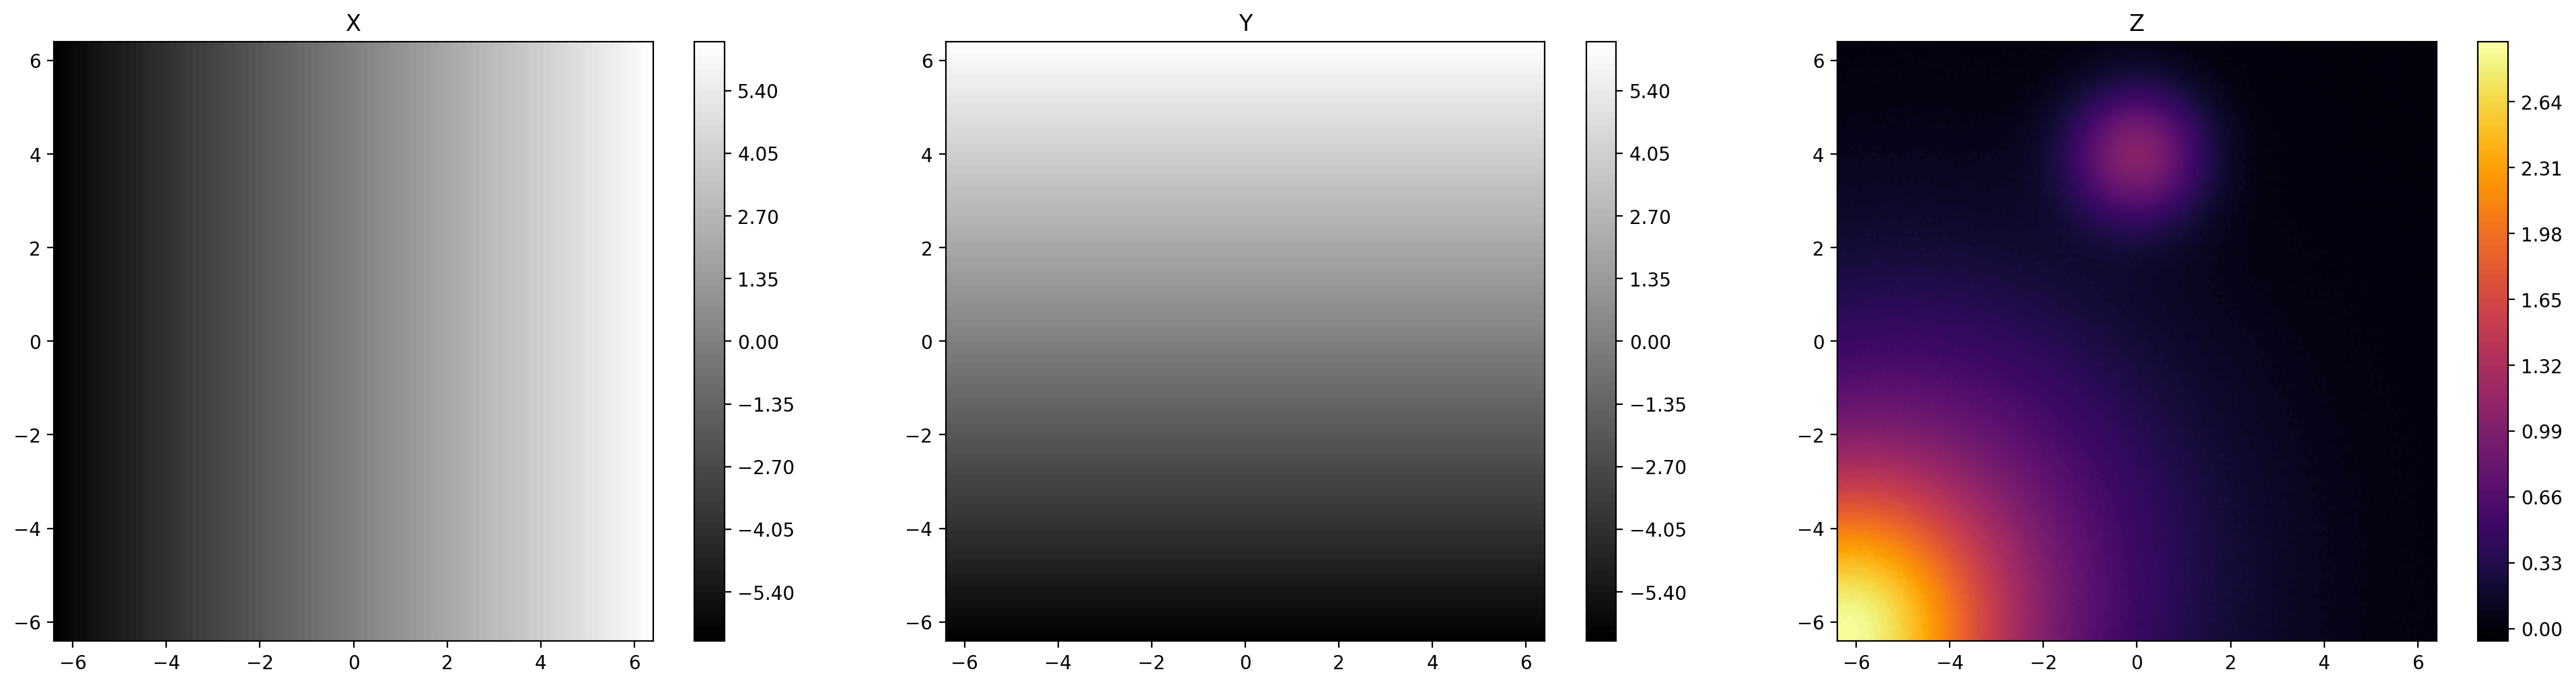

In [11]:
plot_grids_xyz(x_grid[0], y_grid[0], z_grid[0])

In [12]:
# Instatiate the physics config
robot_model = RobotModelConfig(robot_type="marv")
world_config = WorldConfig(x_grid=x_grid, y_grid=y_grid, z_grid=z_grid, grid_res=grid_res, max_coord=max_coord, k_stiffness=30000)
physics_config = PhysicsEngineConfig(num_robots=num_robots)

Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.robot_cache/marv_0.080_192.pt
Robot has 1023 points


In [13]:
# Controls
traj_length = 5.0  # seconds
n_iters = int(traj_length / physics_config.dt)
speed = 1.0  # m/s forward
omega = -0.5  # rad/s yaw
controls = robot_model.get_controls(torch.tensor([speed, omega]))
flipper_controls = torch.zeros_like(controls)

In [14]:
for cfg in [robot_model, world_config, physics_config]:
    cfg.to(device)

In [15]:
engine = DPhysicsEngine(physics_config, robot_model, device)

In [16]:
x0 = torch.tensor([-6, -6, 3.]).to(device).repeat(num_robots, 1)
xd0 = torch.zeros_like(x0)
R0 = torch.eye(3).to(device).repeat(num_robots, 1, 1)
omega0 = torch.zeros_like(x0)
thetas0 = torch.zeros(num_robots, 4).to(device)
local_robot_points0 = robot_model.robot_points.to(device).repeat(num_robots, 1, 1)
controls_all = torch.cat((controls, flipper_controls)).unsqueeze(0).repeat(n_iters, num_robots, 1).to(device)

In [17]:
# Set joint rotational velocities, we want to follow a sine wave, so we set the joint velocities to the derivative of the sine wave
# We want to go +- pi/6 5 times in 10 seconds
amplitude = torch.pi
periods = traj_length / 10.
rot_vels = torch.cos(torch.linspace(0, periods * 2 * np.pi, n_iters)) * amplitude
rot_vels = rot_vels.unsqueeze(-1).repeat(1, num_robots)
controls_all[:, :, len(controls)] = rot_vels
controls_all[:, :, len(controls) + 1] = rot_vels
controls_all[:, :, len(controls) + 2] = -rot_vels
controls_all[:, :, len(controls) + 3] = -rot_vels

In [18]:
init_state = PhysicsState(x0, xd0, R0, omega0, thetas0)

In [19]:
bench_state = PhysicsState.dummy_like(init_state)

In [20]:
compile_opts = {"max-autotune": True, "triton.cudagraphs": True}
if DYNAMO_DEBUG:
    compile_opts |= {"trace.enabled": True, "trace.graph_diagram": True}

In [21]:
print(torch._inductor.list_mode_options())
print(torch._inductor.list_options())

{'default': {}, 'reduce-overhead': {'triton.cudagraphs': True}, 'max-autotune-no-cudagraphs': {'max_autotune': True}, 'max-autotune': {'max_autotune': True, 'triton.cudagraphs': True}}
['TYPE_CHECKING', 'enable_auto_functionalized_v2', 'debug', 'disable_progress', 'verbose_progress', 'fx_graph_cache', 'fx_graph_remote_cache', 'autotune_local_cache', 'autotune_remote_cache', 'force_disable_caches', 'sleep_sec_TESTING_ONLY', 'custom_op_default_layout_constraint', 'cpp_wrapper', 'abi_compatible', 'c_shim_version', 'dce', 'static_weight_shapes', 'size_asserts', 'nan_asserts', 'pick_loop_orders', 'inplace_buffers', 'allow_buffer_reuse', 'memory_planning', 'memory_pool', 'benchmark_harness', 'epilogue_fusion', 'epilogue_fusion_first', 'pattern_matcher', 'b2b_gemm_pass', 'post_grad_custom_pre_pass', 'post_grad_custom_post_pass', 'joint_custom_pre_pass', 'joint_custom_post_pass', 'pre_grad_custom_pass', '_pre_fusion_custom_pass', 'split_cat_fx_passes', 'efficient_conv_bn_eval_fx_passes', 'is_p

In [22]:
if COMPILE:
    # run all torch compilation
    engine = torch.compile(engine, options=compile_opts)
    _ = engine(bench_state, controls_all[0], world_config)

I0103 17:54:52.711000 37311 torch/_dynamo/utils.py:859] [0/0] ChromiumEventLogger initialized with id 5796e492-ae41-49f7-a50e-0492e93dcf42
I0103 17:54:52.712000 37311 torch/_dynamo/logging.py:57] [0/0] Step 1: torchdynamo start tracing forward /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/engine/engine.py:24
I0103 17:54:53.600000 37311 torch/_dynamo/logging.py:57] [0/0] Step 1: torchdynamo done tracing forward (RETURN_VALUE)
I0103 17:54:53.618000 37311 torch/_dynamo/logging.py:57] [0/0] Step 2: calling compiler function inductor
I0103 17:54:54.843000 37311 torch/_dynamo/logging.py:57] [0/0] Step 2: done compiler function inductor
I0103 17:54:54.865000 37311 torch/fx/experimental/symbolic_shapes.py:3646] [0/0] produce_guards


In [23]:
%%timeit -o
_ = engine(bench_state, controls_all[0],world_config)

350 μs ± 15.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 350 μs ± 15.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [24]:
states = deque(maxlen=n_iters)
dstates = deque(maxlen=n_iters)
auxs = deque(maxlen=n_iters)

In [25]:
%%time 
state = deepcopy(init_state)
i = 0
for ctrl in controls_all:
    state, der, aux = engine(state, ctrl, world_config)
    states.append(deepcopy(state))
    dstates.append(der)
    auxs.append(aux)
    i += 1

CPU times: user 237 ms, sys: 14.2 ms, total: 251 ms
Wall time: 283 ms


In [26]:
from flipper_training.engine.engine_state import vectorize_iter_of_states as vectorize_states

In [27]:
states_vec = vectorize_states(states)
dstates_vec = vectorize_states(dstates)
aux_vec = vectorize_states(auxs)

<Axes: title={'center': 'Birdview of trajectory'}, xlabel='x', ylabel='y'>

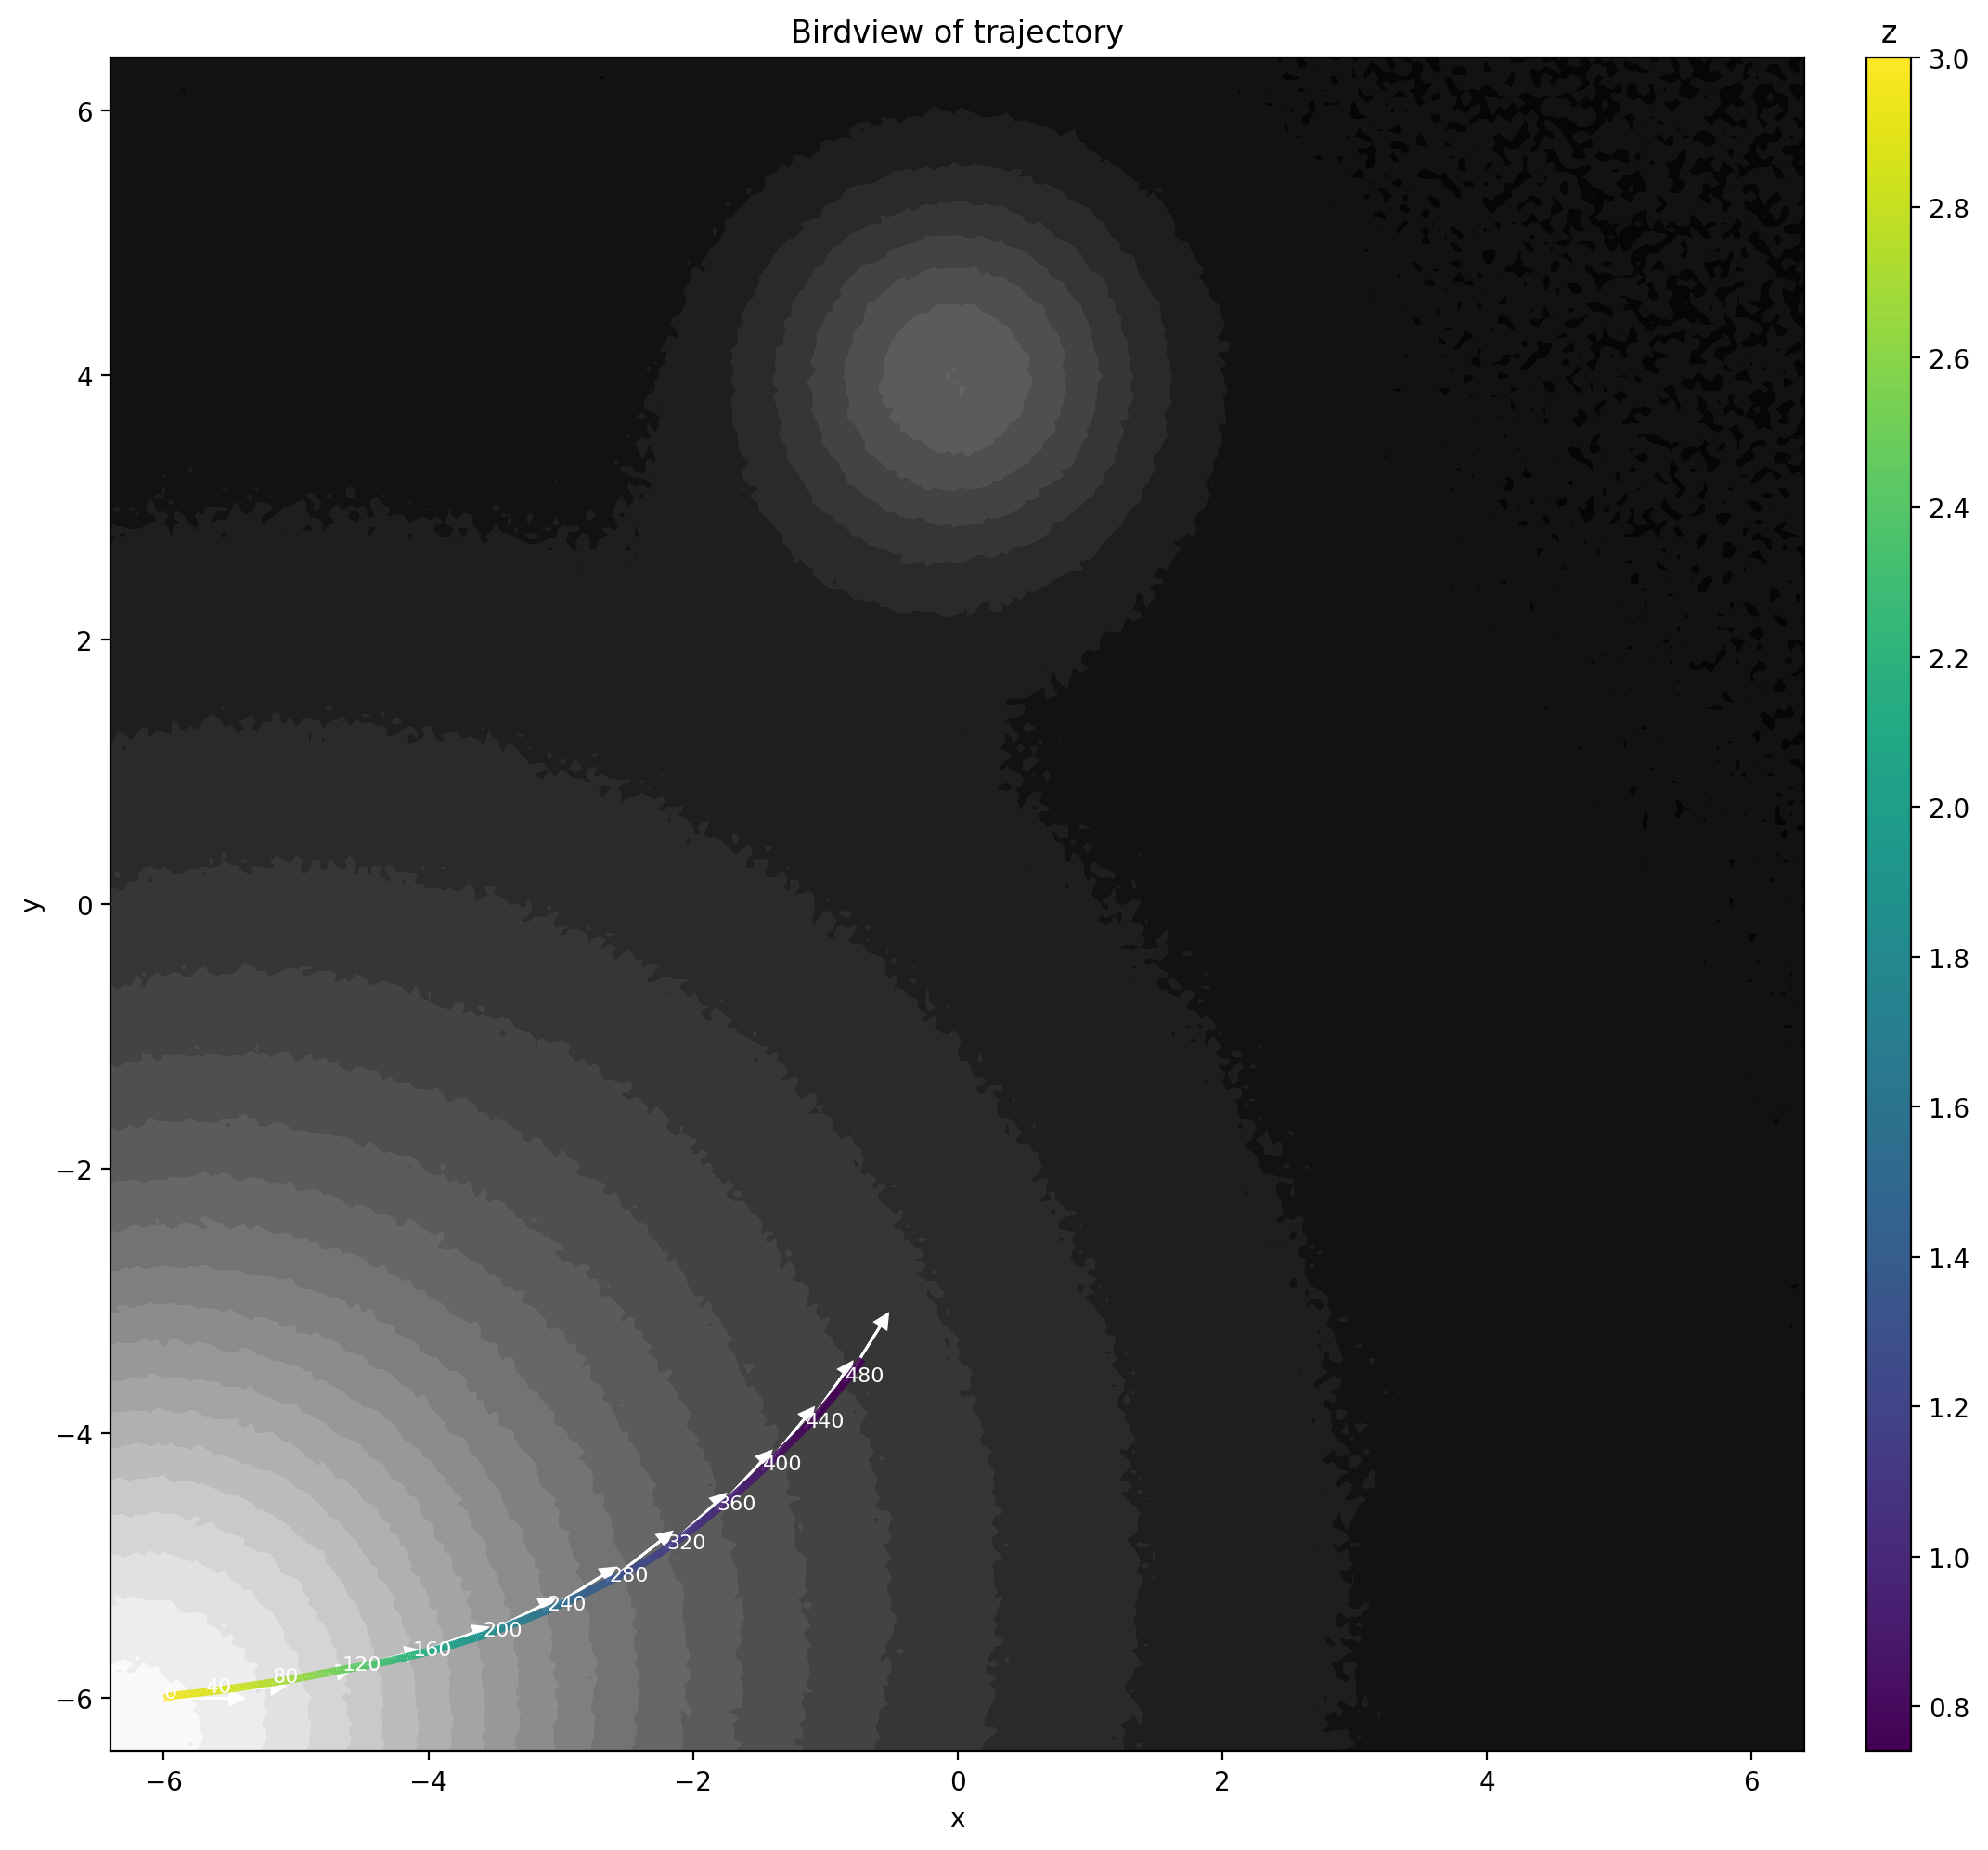

In [28]:
plot_birdview_trajectory(world_config, states, iter_step=40)

In [29]:
ROBOT_IDX = 0

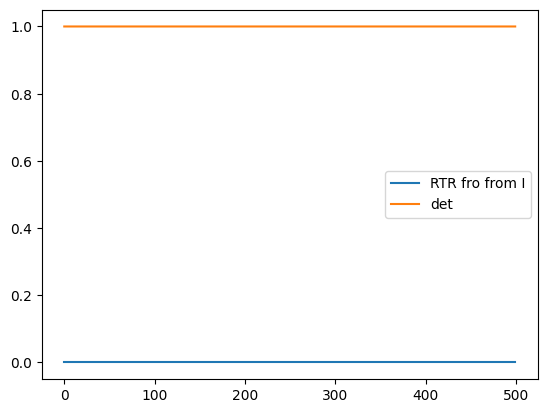

In [30]:
# Analyze the rotation matrices to check for numerical stability
R = states_vec.R[:, ROBOT_IDX].cpu()
RTRs = torch.bmm(R, R.permute(0, 2, 1))
diffs = torch.norm(RTRs - torch.eye(3), dim=(1, 2))
dets = torch.linalg.det(R)
plt.plot(diffs, label="RTR fro from I")
plt.plot(dets, label="det")
plt.legend()

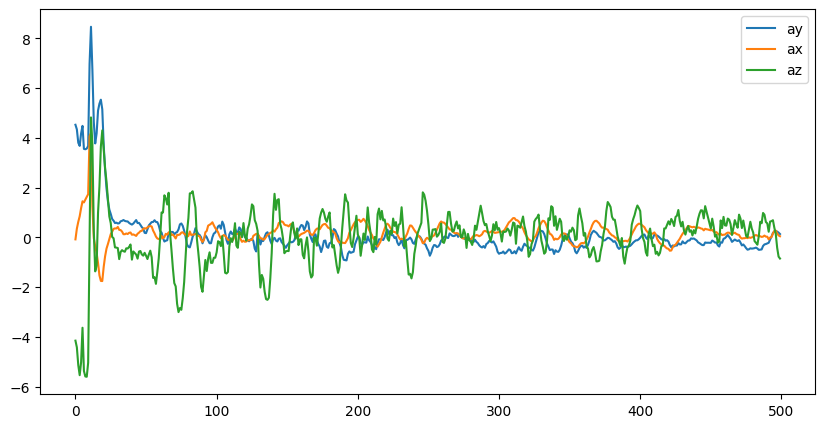

In [31]:
# Plot components of acceleration
ay, ax, az = dstates_vec.xdd[:, ROBOT_IDX].T.cpu().numpy()
plt.figure(figsize=(10, 5))
plt.plot(ay, label='ay')
plt.plot(ax, label='ax')
plt.plot(az, label='az')
plt.legend()

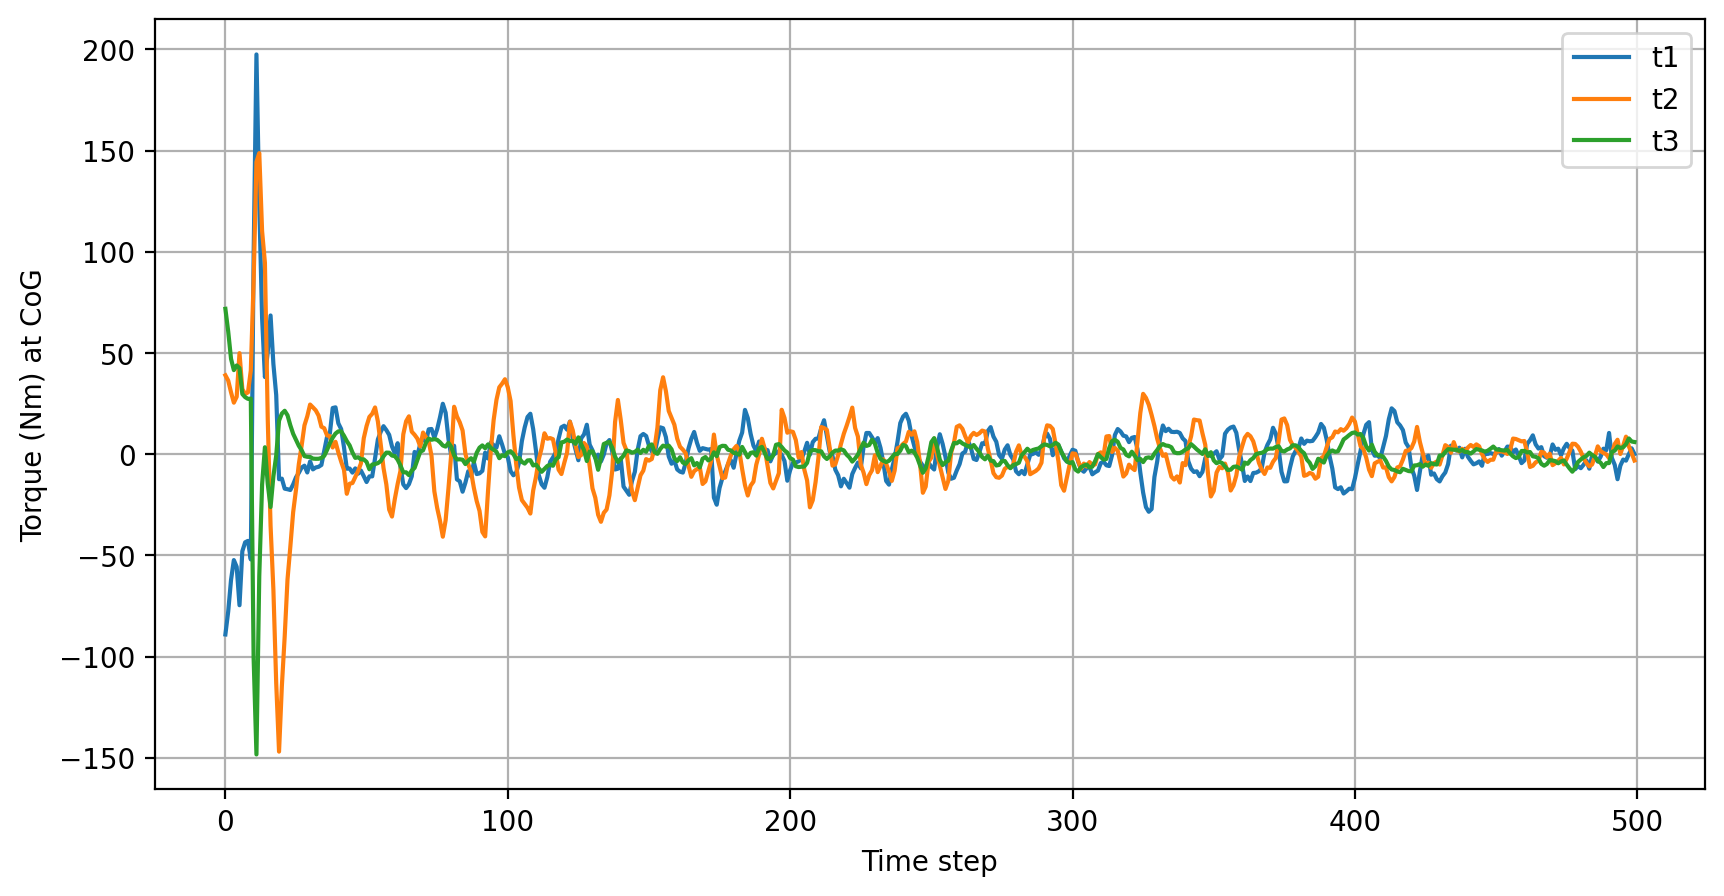

In [32]:
# Plot components of torque
t1, t2, t3 = aux_vec.torque[:, ROBOT_IDX].T.cpu().numpy()
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(t1, label='t1')
plt.plot(t2, label='t2')
plt.plot(t3, label='t3')
plt.grid()
plt.xlabel('Time step')
plt.ylabel('Torque (Nm) at CoG')
plt.legend()

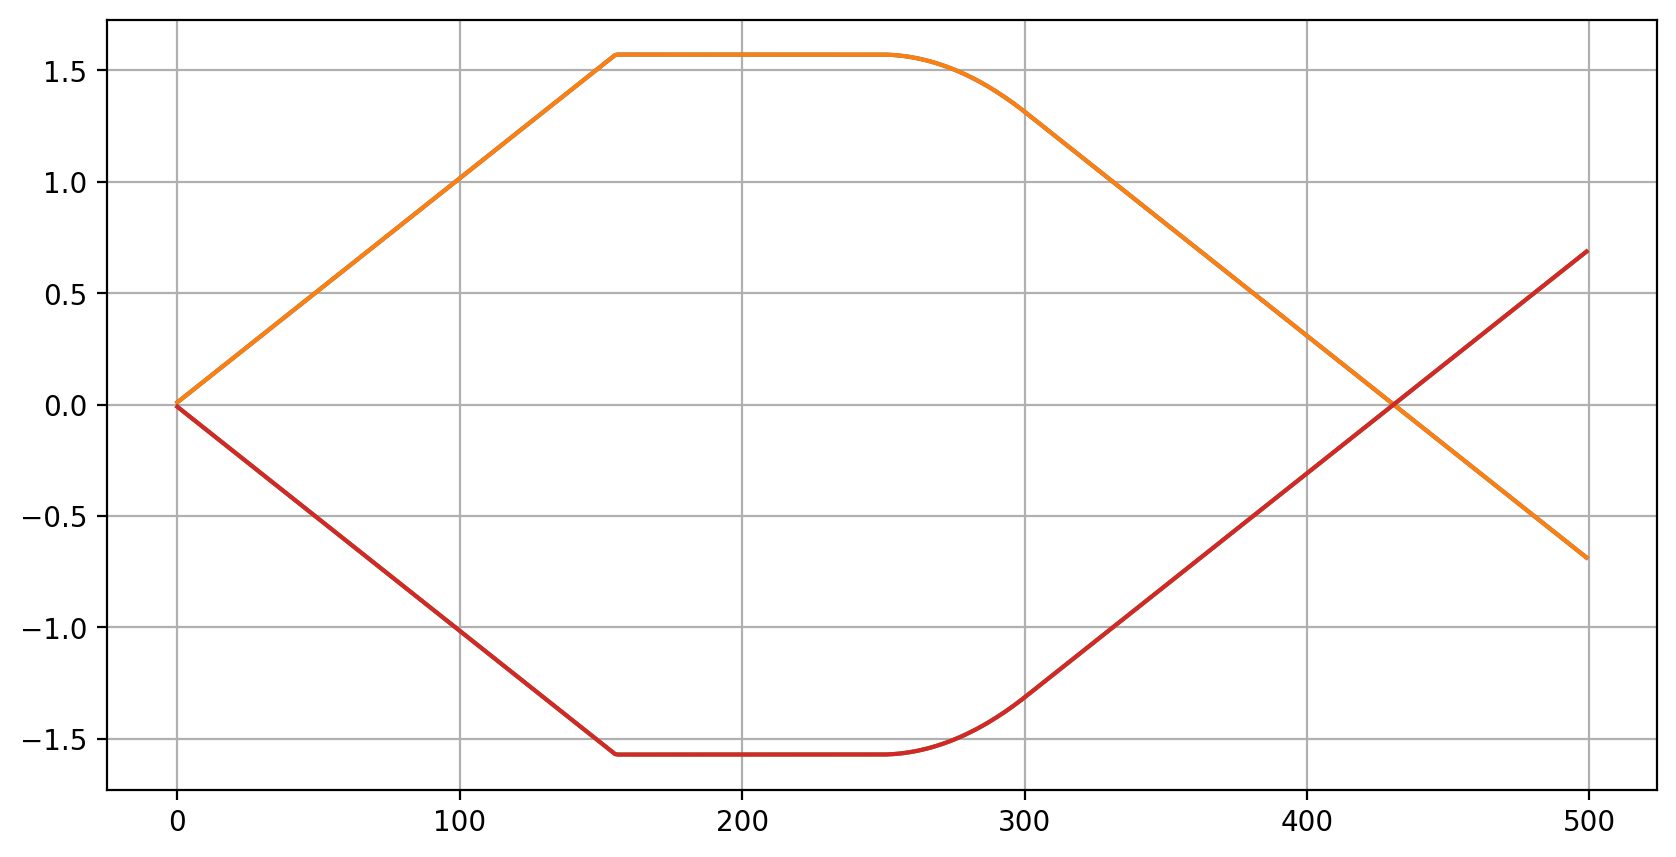

In [33]:
# Joint angles
plt.figure(figsize=(10, 5), dpi=200)
theta1, theta2, theta3, theta4 = states_vec.thetas[:, ROBOT_IDX].T.cpu().numpy()
plt.plot(theta1, label='theta1')
plt.plot(theta2, label='theta2')
plt.plot(theta3, label='theta3')
plt.plot(theta4, label='theta4')
plt.grid()

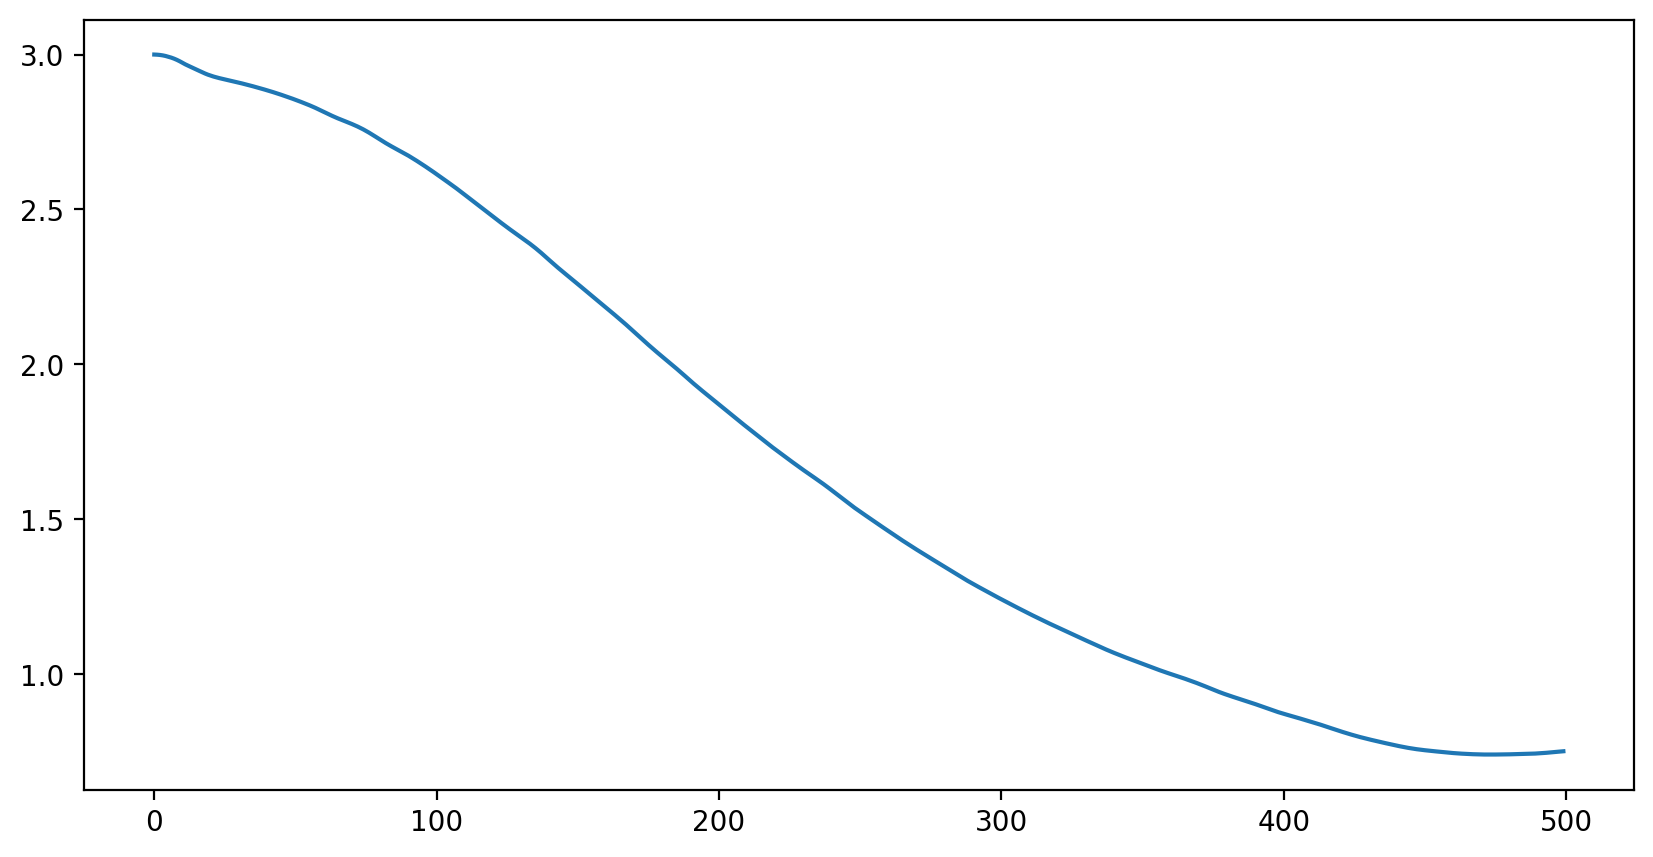

In [34]:
# Height of the robot
plt.figure(figsize=(10, 5), dpi=200)
z = states_vec.x[:, ROBOT_IDX, 2].cpu().numpy()
plt.plot(z)

In [35]:
plot_3d_trajectory(world_config, states, auxs)

In [36]:
if SHOW_ANIMATION:
    from flipper_training.vis.animator import animate_trajectory
    animate_trajectory(world_config, physics_config, states, auxs, ROBOT_IDX)

2025-01-03 17:55:01.977 Python[37311:10771328] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/yj/_6b0pqvs5xg33v_xy5q2v9_40000gn/T/org.python.python.savedState
2025-01-03 17:55:02.194 Python[37311:10771328] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-03 17:55:02.194 Python[37311:10771328] +[IMKInputSession subclass]: chose IMKInputSession_Modern
